In [2]:
# Add src module to python path
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
from tqdm import tqdm
import torch
from torch import nn
import random
import numpy as np
from src.experiments.experiment_configs import experiment_configs
from src.modules.utils import cos_sim_metric, mlp_sim_metric, test_verification_performance, evaluate_recall_at_k
from src.modules.utils_embeddings import EmbeddingGenerator
from src.modules.data import EmbeddingDataset
from src.modules.models import ClassificationModel, MLPClassifier
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
conf_name = "classification_loss_7"
conf = experiment_configs[conf_name]
conf_mlp = experiment_configs[conf_name + '_mlp']
annotation_file = "../test_info.csv"
img_dir = "../test_resized"
emb_dir = "../embeddings"
img_out = "../embeddings/img_out"
tensor_out = "tensorboard_log"

model = ClassificationModel(**conf['model_params'])

checkpoint = torch.load('../checkpoints/' + conf_name + '_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

dataset_test_emb = EmbeddingDataset(annotation_file, img_dir, transform=transforms.Compose([transforms.CenterCrop(256), transforms.ToTensor()]), validation=False)
emb_gen = EmbeddingGenerator(model, dataset_test_emb, conf['batch_size'], img_out, emb_dir, tensor_out, conf_name, 'cuda', 4)

checkpoint_mpl = torch.load('../checkpoints/' + conf_name + '_mlp_checkpoint.pt')
mlp = MLPClassifier(**conf_mlp['model_params'])
mlp.load_state_dict(checkpoint_mpl['model_state_dict'])

C:\Users\leogo\anaconda3\envs\dll\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\leogo\anaconda3\envs\dll\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [11]:
embs, labels, filenames = emb_gen.compute_embeddings(disable=True)
torch.save({'embs': embs, 'labels': labels, 'filenames': filenames}, 'embs_analysis.pt')

100%|██████████| 426/426 [16:46<00:00,  2.36s/it]


In [79]:
df = pd.read_csv('../all_data_info.csv')
df = df[df['in_train'] == False]
df = df.sort_values('artist')
df['val'] = False
df = df.rename({'new_filename': 'filename'}, axis=1)
columns = list(df.columns)
columns.remove('filename')
columns = ['filename'] + columns
df = df.reindex(columns=columns)

# label_dict = {}
# label_index = 0
# for x in df.iterrows():
#     row = x[1]
#     if row['artist'] not in label_dict:
#         label_dict[row['artist']] = label_index
#         label_index += 1

# df['artist'] = df.apply(lambda x: label_dict[x['artist']], axis=1)

df.to_csv('../test_vis_info.csv', index=False)

In [23]:
df = pd.read_csv('../test_vis_info.csv')
df = df[df['in_train'] == False].reset_index()

In [16]:
def plot_artist_vs_artist(df, artist1, artist2):

    # Create filename and date lists for each artist
    df_artist1 = df[df['artist'] == artist1].dropna()
    df_artist1['date'] = df_artist1['date'].apply(lambda x: x.split('.')[1] if x.startswith('c') else x)
    df_artist1['date'] = pd.to_numeric(df_artist1['date'])
    df_artist1 = df_artist1.sort_values('date')
    artist1_filenames = list(df_artist1['filename'])
    artist1_dates = list(df_artist1['date'])

    df_artist2 = df[df['artist'] == artist2].dropna()
    df_artist2['date'] = df_artist2['date'].apply(lambda x: x.split('.')[1] if x.startswith('c') else x)
    df_artist2['date'] = pd.to_numeric(df_artist2['date'])
    df_artist2 = df_artist2.sort_values('date')
    artist2_filenames = list(df_artist2['filename'])
    artist2_dates = list(df_artist2['date'])

    # Load embeddings
    checkpoint = torch.load('embs_analysis.pt')
    embs, labels, filenames = checkpoint['embs'], checkpoint['labels'], checkpoint['filenames']
    emb_dict = {file: {'emb': emb, 'label': label} for emb, label, file in zip(embs, labels, filenames)}

    artist1_embs = np.array([emb_dict[file]['emb'].numpy() for file in artist1_filenames])
    artist2_embs = np.array([emb_dict[file]['emb'].numpy() for file in artist2_filenames])

    # Compute embedding similarities
    sim_matrix = cos_sim_metric(artist1_embs, artist2_embs)

    fig, ax = plt.subplots(figsize=(12.5,10))
    sns.heatmap(sim_matrix, xticklabels=False, yticklabels=False, vmin=0.3, vmax=1.0, ax=ax)
    #tick_locator = plt.MaxNLocator(5)
    # ax.xaxis.set_major_locator(tick_locator)
    # ax.yaxis.set_major_locator(tick_locator)
    ax.invert_yaxis()
    title = artist1 +' vs ' + artist2
    ax.set_title(title, fontsize=28)
    ax.set_xlabel('Year (ascending)', fontsize=20)
    ax.set_ylabel('Year (ascending)', fontsize=20)
    print(artist1_dates[0])
    print(artist1_dates[16])

    # plt.setp(ax.xaxis.get_label(), visible=True, text='Dates')
    # plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')

    plt.savefig('figs/' + title + '.png')
    plt.show()

def plot_artist_self(df, artist):
    plot_artist_vs_artist(df, artist, artist)

def plot_styles(df, styles):

    idx = []
    for style in styles:
        idx += list(df[df['style'] == style].sample(10).index)

    # Create filename and date lists for each artist
    df_styles = df.loc[idx]
    df_styles = df_styles.sort_values('style')
    styles_filenames = list(df_styles['new_filename'])
    styles_names = list(df_styles['style'])

    checkpoint = torch.load('embs.pt')
    embs, labels, filenames = checkpoint['embs'], checkpoint['labels'], checkpoint['filenames']
    emb_dict = {file: {'emb': emb, 'label': label} for emb, label, file in zip(embs, labels, filenames)}
    styles_embs = np.array([emb_dict[file]['emb'].numpy() for file in styles_filenames])

    # Compute embedding similarities
    sim_matrix = cos_sim_metric(styles_embs, styles_embs)

    fig, ax = plt.subplots(figsize=(12.5,10))
    sns.heatmap(sim_matrix, xticklabels=styles_names, yticklabels=styles_names, vmin=0.4, vmax=1.0, ax=ax)
    tick_locator = plt.MaxNLocator(5)

    ax.invert_yaxis()
    title = styles
    ax.set_title(title, fontsize=28)
    ax.set_xlabel('Style', fontsize=20)
    ax.set_ylabel('Style', fontsize=20)

    plt.savefig('figs/styles.png')
    plt.show()


1895
1902


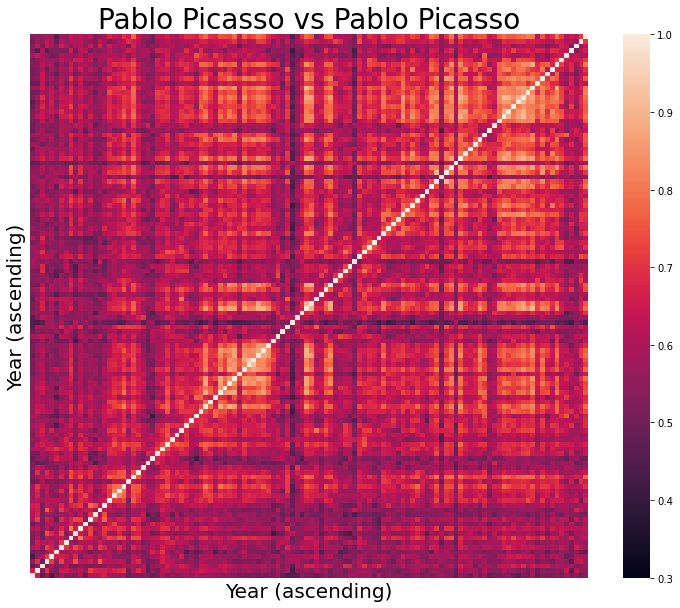

In [17]:
plot_artist_self(df, 'Pablo Picasso')

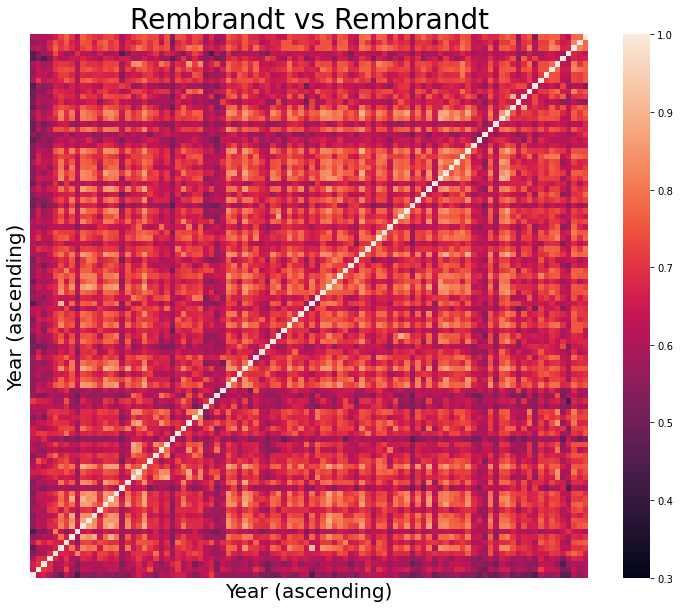

In [84]:
plot_artist_self(df, 'Rembrandt')

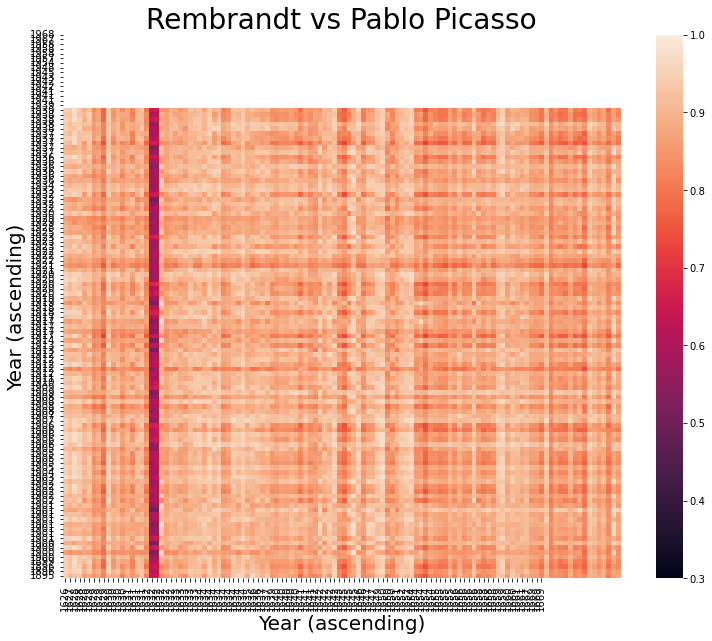

In [80]:
plot_artist_vs_artist(df, 'Rembrandt', 'Pablo Picasso')

In [2]:
df = pd.read_csv('../test_vis_info.csv')

In [4]:
def plot_mean_sim(df, values, criterion, labels=True, title=None):

    # Compute similarity matrix for embeddings
    embs = torch.load('embs_analysis.pt')['embs']
    embs = [emb.numpy() for emb in embs]
    sim_matrix = cos_sim_metric(embs, embs)

    # Get indices of paintings per value
    value_dict = {}
    for value in values:
        value_df = df[df[criterion] == value]
        value_idx = list(value_df.index)
        value_dict[value] = value_idx

    # Generate mean similarity matrix for values
    n = len(values)
    value_sim = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            s1 = values[i]
            s2 = values[j]

            m = sim_matrix[value_dict[s1], :]
            m = m[:, value_dict[s2]]
            if s1 == s2:
                np.fill_diagonal(m, 0)
                
            value_sim[i, j] = np.mean(m)

    fig, ax = plt.subplots(figsize=(12.5,10))
    #values = [val.replace(' ', '\n') for val in values]
    labels = values if labels else labels
    sns.heatmap(value_sim, xticklabels=False, yticklabels=False, ax=ax)

    ax.invert_yaxis()
    if title:
        ax.set_title(title, fontsize=28)
    ax.set_xlabel(criterion, fontsize=20)
    ax.set_ylabel(criterion, fontsize=20)

    plt.tight_layout()
    plt.savefig('figs/' + criterion + '_mean.png')
    plt.show()

    mean_in = np.diag(value_sim)
    mean_out = value_sim.copy()
    np.fill_diagonal(mean_out, 0)

    return mean_in.mean(), mean_out.mean()

   


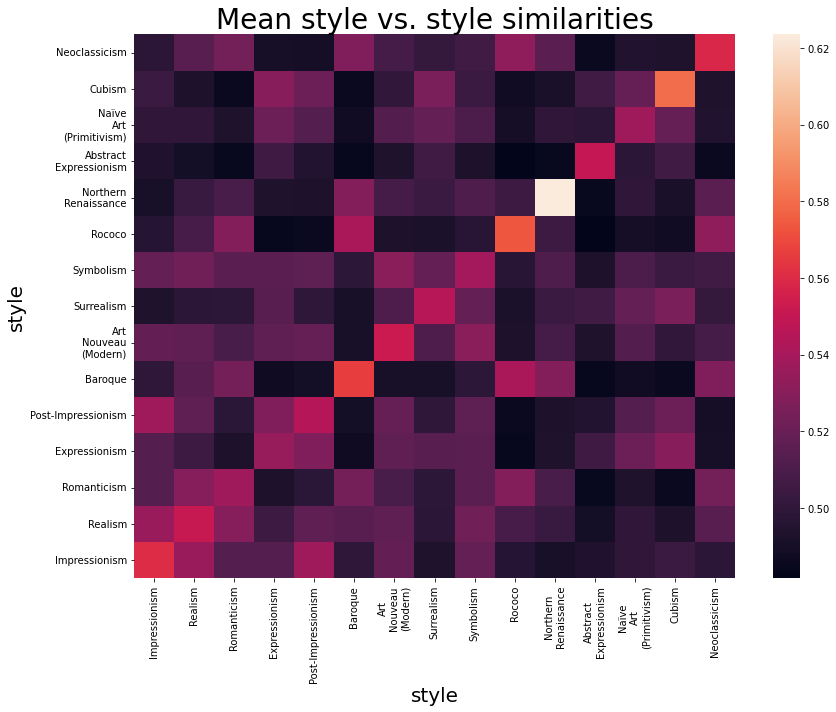

(0.5571001648902894, 0.47153366525967916)

In [7]:
styles = list(df['style'].value_counts()[:15].index)
plot_mean_sim(df, styles, 'style', title='Mean style vs. style similarities')

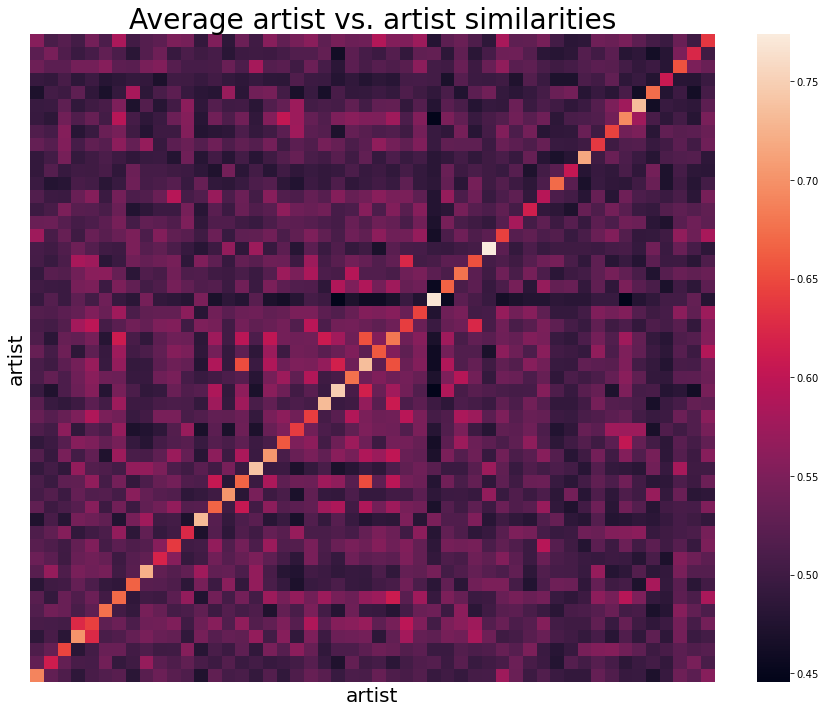

(0.6689022219181061, 0.5070470320940018)

In [5]:
artists = list(df['artist'].value_counts()[:50].index)
plot_mean_sim(df, artists, 'artist', title='Average artist vs. artist similarities')

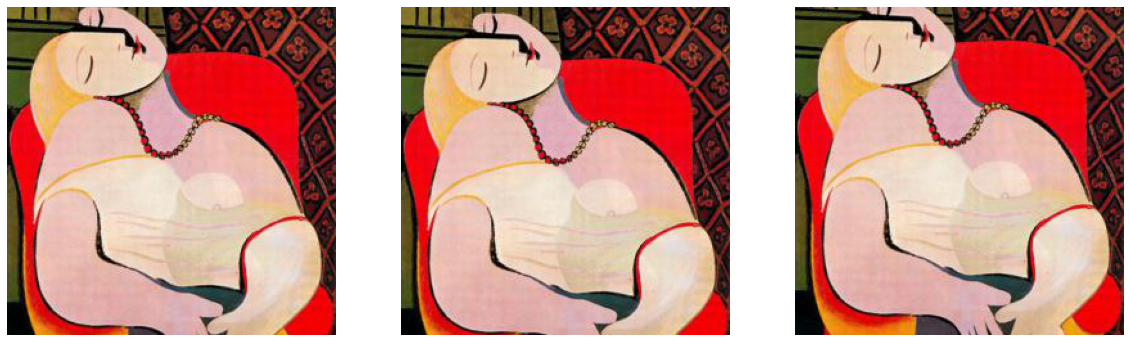

In [8]:
from PIL import Image

fig, axs = plt.subplots(1, 3, figsize=(20,10), )

transform = transforms.RandomCrop(256)

df_crop = pd.read_csv('../all_data_info.csv')
df_crop = df_crop[df_crop['title'] == 'A dream']
sample = df_crop.sample(1)
img_name = sample['new_filename'].iloc[0]
folder = 'train_resized' if sample['in_train'].iloc[0] else 'test_resized'

with open('../' + folder + '/' + img_name, 'rb') as file:
    image = Image.open(file).convert('RGB')
    for i in range(3):
        axs[i].imshow(transform(image))
        axs[i].axis('off')

plt.savefig('figs/crop.png')


Expressionism
Surrealism
Expressionism
Cubism
Surrealism
Naïve Art (Primitivism)
Analytical Cubism
Synthetic Cubism
Expressionism
Neoclassicism
Expressionism
Expressionism
Analytical Cubism
Surrealism
Cubism


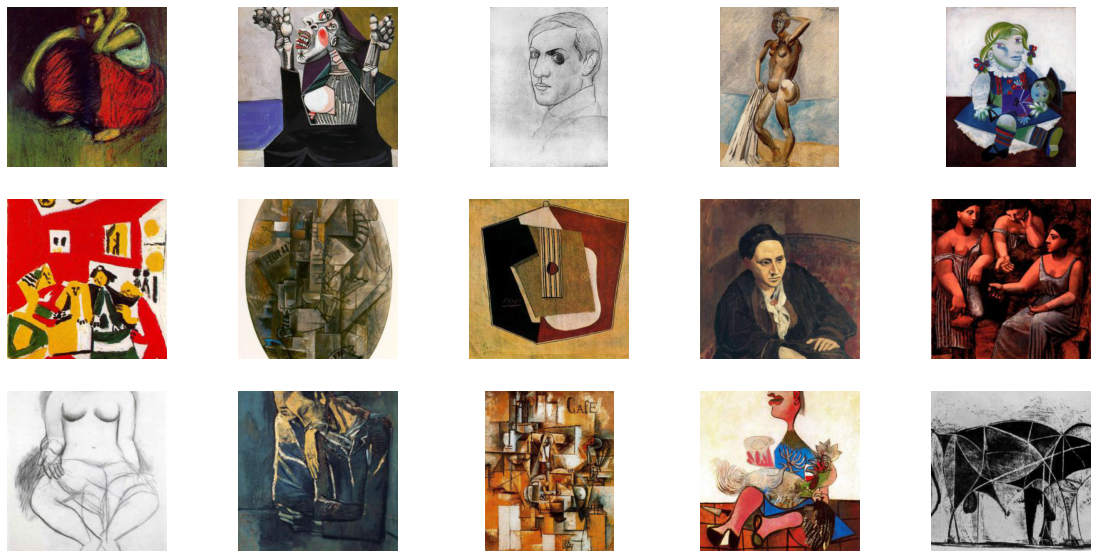

In [30]:
from PIL import Image

fig, axs = plt.subplots(3, 5, figsize=(20,10), )

transform = transforms.RandomCrop(256)

df = pd.read_csv('../all_data_info.csv')
df = df[df['artist'] == 'Pablo Picasso'].dropna()
df['date'] = df['date'].apply(lambda x: x.split('.')[1] if x.startswith('c') else x)
df['date'] = pd.to_numeric(df['date'])

df = df[df['date'] >= 1900]
samples = df.sample(20)

for i in range(3):
    for j in range(5):
        sample = samples.iloc[5*i + j]
        filename = sample['new_filename']
        print(sample['style'])
        folder = 'train_resized' if sample['in_train'] else 'test_resized'

        with open('../' + folder + '/' + filename, 'rb') as file:
            image = Image.open(file).convert('RGB')
            axs[i, j].imshow(image)
            axs[i, j].axis('off')

plt.savefig('figs/browse.png')

In [11]:
checkpoint = torch.load('embs.pt')
embs, labels, filenames = checkpoint['embs'], checkpoint['labels'], checkpoint['filenames']
embs = [emb.numpy() for emb in embs]

test_verification_performance(embs, labels, filenames, '../submission_info.csv', save_submission=True, submission_name='submission_vis.csv')

0.915532273077776

In [57]:
pairs_vis = pd.read_csv('submission_vis.csv')
pairs_vis.head()

index      image1      image2  positive  sameArtist
0      0  100005.jpg  100004.jpg     False    0.468257
1      1  100014.jpg  100004.jpg     False    0.540284
2      2  100014.jpg  100005.jpg     False    0.592838
3      3  100022.jpg  100004.jpg     False    0.503119
4      4  100022.jpg  100005.jpg     False    0.506154

In [59]:
pos_scores = pairs_vis[pairs_vis['positive'] == True]['sameArtist']
neg_scores = pairs_vis[pairs_vis['positive'] == False]['sameArtist']

print(len(pos_scores), len(neg_scores))

283485 21632562


In [64]:
sns.distplot(data=pairs_vis, x='sameArtist', hue='positive', log_scale=(False, True))

TypeError: distplot() got an unexpected keyword argument 'data'

In [1]:
df2 = pd.read_csv('../all_data_info.csv')
artists = set(df2['artist'].unique())
artists_train = set(df2[df2['in_train']]['artist'].unique())
artists_test = artists - artists_train
df2 = df2[df2['artist'].isin(artists_test)]
counts = df2['artist'].value_counts()

artists_test = [artist for artist in artists_test if counts[artist] >= 5]

NameError: name 'pd' is not defined

In [ ]:
plot_mean_sim(df, artists_test, 'artist', labels=False)

In [20]:
pairs = pd.read_csv('../submission_info.csv')

images = set(df2['new_filename'])

new_pairs = pairs[~pairs['image1'].isin(images) & ~pairs['image2'].isin(images)]

new_pairs.to_csv('../submission_one_shot2.csv')

In [21]:
test_verification_performance(embs, labels, filenames, '../submission_one_shot2.csv', save_submission=False)

0.9227404239942918

In [3]:
df2 = pd.read_csv('../all_data_info.csv')
artists = set(df2['artist'].unique())
artists_train = set(df2[df2['in_train']]['artist'].unique())
artists_test = artists - artists_train
df2 = df2[df2['artist'].isin(artists_test)]
counts = df2['artist'].value_counts()

checkpoint = torch.load('embs.pt')
embs, labels, filenames = checkpoint['embs'], checkpoint['labels'], checkpoint['filenames']
embs = np.array([emb.numpy() for emb in embs])
labels = np.array(labels)

df_unseen = pd.read_csv('../test_vis_info.csv')
df_unseen = df_unseen[df_unseen['artist'].isin(artists_train)]

unseen_idx = list(df_unseen.index)
unseen_embs = embs[unseen_idx]
unseen_labels = labels[unseen_idx]

# sim_matrix_unseen = cos_sim_metric(unseen_embs, embs)
sim_matrix = cos_sim_metric(embs, embs)


In [5]:
print(len(df2))

3065


In [7]:
checkpoint = torch.load('embs_analysis.pt')
embs, labels, filenames = checkpoint['embs'], checkpoint['labels'], checkpoint['filenames']
embs = np.array([emb.numpy() for emb in embs])
labels = np.array(labels)
sim_matrix = cos_sim_metric(embs, embs)

# Get indices of paintings per value
df = pd.read_csv('../test_vis_info.csv')
values = list(df['artist'].value_counts()[:50].index)
value_dict = {}
for value in values:
    value_df = df[df['artist'] == value]
    value_idx = list(value_df.index)
    value_dict[value] = value_idx

# Generate mean similarity matrix for values
n = len(values)
value_sim = np.empty((n,n))
for i in range(n):
    for j in range(n):
        s1 = values[i]
        s2 = values[j]

        m = sim_matrix[value_dict[s1], :]
        m = m[:, value_dict[s2]]
        if s1 == s2:
            np.fill_diagonal(m, 0)
            
        value_sim[i, j] = np.mean(m)

np.fill_diagonal(value_sim, 0)

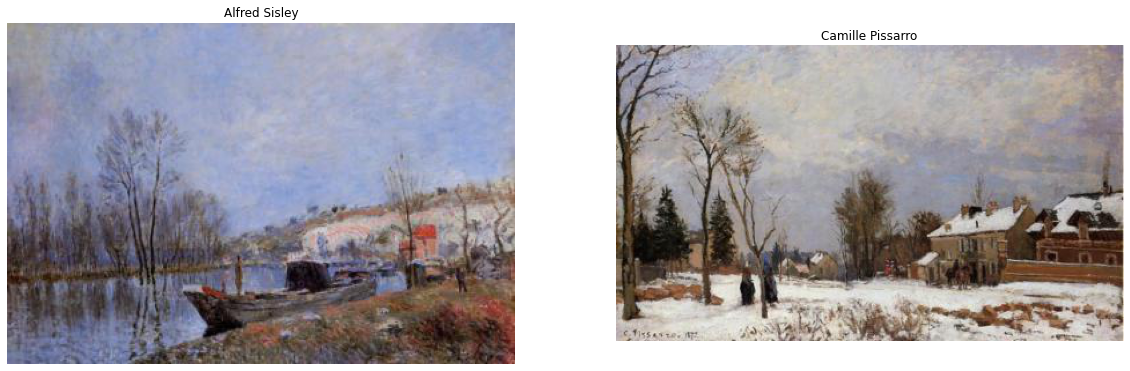

In [9]:
from PIL import Image

sim = value_sim
idx1, idx2 = np.unravel_index(np.argmax(sim), sim.shape)
a1 = values[idx1.item()]
a2 = values[idx2.item()]
a = [a1, a2]

idx1 = list(df[df['artist'] == a1].index)
idx2 = list(df[df['artist'] == a2].index)

filenames1 = list(df[df['artist'] == a1]['filename'])
filenames2 = list(df[df['artist'] == a2]['filename'])

a_sim = sim_matrix[idx1, :]
a_sim = a_sim[:, idx2]

idx1, idx2 = np.unravel_index(np.argmax(a_sim), a_sim.shape)
file1 = filenames1[idx1]
file2 = filenames2[idx2]

fig, axs = plt.subplots(1, 2, figsize=(20,10))

for i, file in enumerate([file1, file2]):
    with open('../test_resized/' + file, 'rb') as f:
        img = Image.open(f).convert('RGB')
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(a[i])
plt.savefig('figs/similar_artists.png')


In [10]:
print(np.mean(a_sim))

0.65369004


In [67]:
from sklearn.metrics import roc_curve

pairs_mlp = pd.read_csv('../mlp_submission.csv')
pairs_same = pd.read_csv('submission_vis.csv')

ValueError: continuous format is not supported

In [69]:
fpr, tpr, _ = roc_curve(pairs_same['positive'], pairs_mlp['sameArtist'])

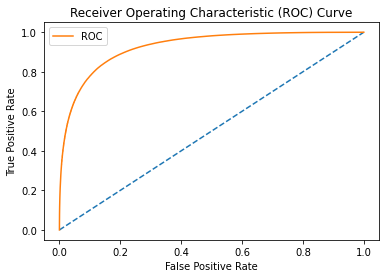

In [75]:
line = np.linspace(0, 1, 1000)
plt.plot(line, line, '--')
plt.plot(fpr, tpr, label='ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='upper left')
plt.savefig('figs/ROC.png')
plt.show()